In [212]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff
import pandas as pd
import xarray as xr
import numpy as np

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**load two years data for the Lord Howe AMP and surrounding area, resample to spatial resolution to 0.02 dd to match that of the SSTAARS dataset**

In [124]:
data = dc.load(product='modis_oc_1d', lat=(-27,-36), lon=(157,161), time=('2009-01-01','2010-12-31'), resolution=(-0.02,0.02), measurements=(['sst']))

In [125]:
data = mask_invalid_data(data)

In [261]:
data

<xarray.Dataset>
Dimensions:    (latitude: 450, longitude: 200, time: 729)
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01T11:59:59.999999 ... 2010-12-31T11:59:59.999999
  * latitude   (latitude) float64 -27.01 -27.03 -27.05 ... -35.95 -35.97 -35.99
  * longitude  (longitude) float64 157.0 157.0 157.0 157.1 ... 160.9 161.0 161.0
Data variables:
    sst        (time, latitude, longitude) float32 25.78 25.61 ... 22.04 21.92
Attributes:
    crs:      EPSG:4326

**round the lat and lon values to two decimal points**

In [354]:
data.coords['latitude']=np.around(data.latitude,decimals=2)
data.coords['longitude']=np.around(data.longitude,decimals=2)

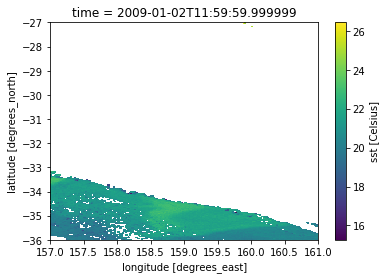

In [126]:
data.sst[1].plot()

**load the LH AMP shapefile**

<Figure size 432x288 with 0 Axes>

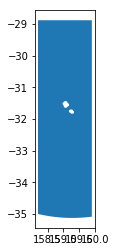

In [128]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'

#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)


#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()

plt.show()


**load the SSTAARS dataset (.nc)**

In [129]:
ncPath = '/g/data/u46/users/zxh547/SSTAARS.nc'

In [130]:
SSTAARS = xr.open_dataset(ncPath,decode_times=False)

In [355]:
SSTAARS

<xarray.Dataset>
Dimensions:         (LATITUDE: 4500, LONGITUDE: 6000, MONTH_OF_YEAR: 12)
Coordinates:
  * MONTH_OF_YEAR   (MONTH_OF_YEAR) float64 1.5 2.5 3.5 4.5 ... 10.5 11.5 12.5
  * LATITUDE        (LATITUDE) float64 -69.99 -69.97 -69.95 ... 19.97 19.99
  * LONGITUDE       (LONGITUDE) float64 70.01 70.03 70.05 ... 189.9 190.0 190.0
    DEPTH           float32 ...
Data variables:
    TEMP_10th_perc  (MONTH_OF_YEAR, LATITUDE, LONGITUDE) float32 ...
    TEMP_20th_perc  (MONTH_OF_YEAR, LATITUDE, LONGITUDE) float32 ...
    TEMP_30th_perc  (MONTH_OF_YEAR, LATITUDE, LONGITUDE) float32 ...
    TEMP_40th_perc  (MONTH_OF_YEAR, LATITUDE, LONGITUDE) float32 ...
    TEMP_50th_perc  (MONTH_OF_YEAR, LATITUDE, LONGITUDE) float32 ...
    TEMP_60th_perc  (MONTH_OF_YEAR, LATITUDE, LONGITUDE) float32 ...
    TEMP_70th_perc  (MONTH_OF_YEAR, LATITUDE, LONGITUDE) float32 ...
    TEMP_80th_perc  (MONTH_OF_YEAR, LATITUDE, LONGITUDE) float32 ...
    TEMP_90th_perc  (MONTH_OF_YEAR, LATITUDE, LONGITUDE) float

**assign the crs attribute to the SSTAARS dataset and change the lat and lon coordinate names to lower cases (matching the MODIS SST data)**

In [356]:
SSTAARS.attrs['crs']=data.crs

SSTAARS = SSTAARS.rename({'LATITUDE':'latitude','LONGITUDE':'longitude'})

In [357]:
SSTAARS

<xarray.Dataset>
Dimensions:         (MONTH_OF_YEAR: 12, latitude: 4500, longitude: 6000)
Coordinates:
  * MONTH_OF_YEAR   (MONTH_OF_YEAR) float64 1.5 2.5 3.5 4.5 ... 10.5 11.5 12.5
  * latitude        (latitude) float64 -69.99 -69.97 -69.95 ... 19.97 19.99
  * longitude       (longitude) float64 70.01 70.03 70.05 ... 189.9 190.0 190.0
    DEPTH           float32 ...
Data variables:
    TEMP_10th_perc  (MONTH_OF_YEAR, latitude, longitude) float32 ...
    TEMP_20th_perc  (MONTH_OF_YEAR, latitude, longitude) float32 ...
    TEMP_30th_perc  (MONTH_OF_YEAR, latitude, longitude) float32 ...
    TEMP_40th_perc  (MONTH_OF_YEAR, latitude, longitude) float32 ...
    TEMP_50th_perc  (MONTH_OF_YEAR, latitude, longitude) float32 ...
    TEMP_60th_perc  (MONTH_OF_YEAR, latitude, longitude) float32 ...
    TEMP_70th_perc  (MONTH_OF_YEAR, latitude, longitude) float32 ...
    TEMP_80th_perc  (MONTH_OF_YEAR, latitude, longitude) float32 ...
    TEMP_90th_perc  (MONTH_OF_YEAR, latitude, longitude) float

**round the lat and lon values to two decimal points (matching the MODIS data)**

In [397]:
SSTAARS.coords['latitude']=np.around(SSTAARS.latitude,decimals=2)
SSTAARS.coords['longitude']=np.around(SSTAARS.longitude,decimals=2)

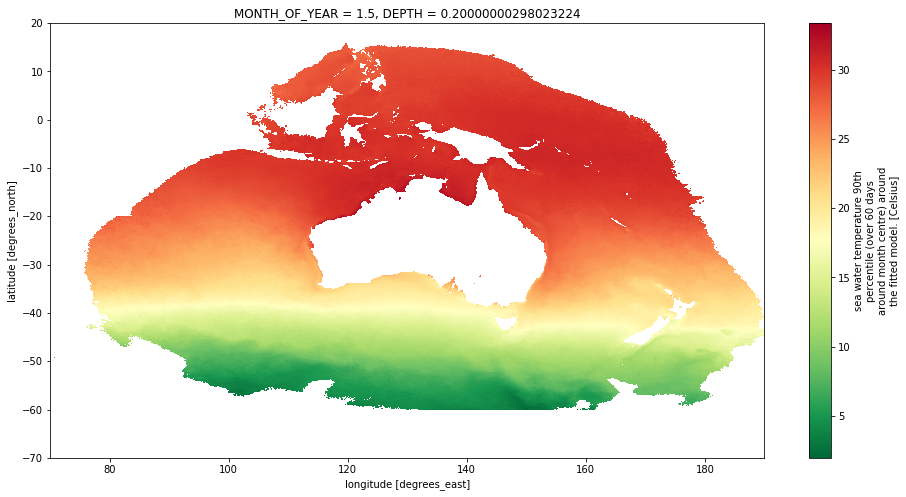

In [358]:
SSTAARS['TEMP_90th_perc'][0,:,:].plot(cmap='RdYlGn_r',figsize=(16,8))

**obtain the 90% percentile data from the SSTAARS data and clip them to the same extent as the loaded MODIS SST data**

In [400]:
Jan_90th = SSTAARS['TEMP_90th_perc'][0,:,:]

Jan_90th = Jan_90th.sel(latitude=slice(-36,-27),longitude=slice(157,161))

In [401]:
Feb_90th = SSTAARS['TEMP_90th_perc'][1,:,:]

Feb_90th = Feb_90th.sel(latitude=slice(-36,-27),longitude=slice(157,161))

In [402]:
Mar_90th = SSTAARS['TEMP_90th_perc'][2,:,:]

Mar_90th = Mar_90th.sel(latitude=slice(-36,-27),longitude=slice(157,161))

In [403]:
Apr_90th = SSTAARS['TEMP_90th_perc'][3,:,:]

Apr_90th = Apr_90th.sel(latitude=slice(-36,-27),longitude=slice(157,161))

In [404]:
May_90th = SSTAARS['TEMP_90th_perc'][4,:,:]

May_90th = May_90th.sel(latitude=slice(-36,-27),longitude=slice(157,161))

In [405]:
Jun_90th = SSTAARS['TEMP_90th_perc'][5,:,:]

Jun_90th = Jun_90th.sel(latitude=slice(-36,-27),longitude=slice(157,161))

In [406]:
Jul_90th = SSTAARS['TEMP_90th_perc'][6,:,:]

Jul_90th = Jul_90th.sel(latitude=slice(-36,-27),longitude=slice(157,161))

In [407]:
Aug_90th = SSTAARS['TEMP_90th_perc'][7,:,:]

Aug_90th = Aug_90th.sel(latitude=slice(-36,-27),longitude=slice(157,161))

In [408]:
Sep_90th = SSTAARS['TEMP_90th_perc'][8,:,:]

Sep_90th = Sep_90th.sel(latitude=slice(-36,-27),longitude=slice(157,161))

In [409]:
Oct_90th = SSTAARS['TEMP_90th_perc'][9,:,:]

Oct_90th = Oct_90th.sel(latitude=slice(-36,-27),longitude=slice(157,161))

In [410]:
Nov_90th = SSTAARS['TEMP_90th_perc'][10,:,:]

Nov_90th = Nov_90th.sel(latitude=slice(-36,-27),longitude=slice(157,161))

In [411]:
Dec_90th = SSTAARS['TEMP_90th_perc'][11,:,:]

Dec_90th = Dec_90th.sel(latitude=slice(-36,-27),longitude=slice(157,161))

**assign CRS attribute to these 90th percentiles**

In [412]:
Jan_90th.attrs['crs']=data.crs
Feb_90th.attrs['crs']=data.crs
Mar_90th.attrs['crs']=data.crs
Apr_90th.attrs['crs']=data.crs
May_90th.attrs['crs']=data.crs
Jun_90th.attrs['crs']=data.crs
Jul_90th.attrs['crs']=data.crs
Aug_90th.attrs['crs']=data.crs
Sep_90th.attrs['crs']=data.crs
Oct_90th.attrs['crs']=data.crs
Nov_90th.attrs['crs']=data.crs
Dec_90th.attrs['crs']=data.crs

In [416]:
data.affine


Affine(0.02000000000000009, 0.0, 157.0,
       0.0, -0.02, -27.0)

In [417]:
Jan_90th.affine

Affine(0.02000000000000009, 0.0, 157.0,
       0.0, 0.02, -36.0)

**import and display the shapefile, on top of the Dec_90th**

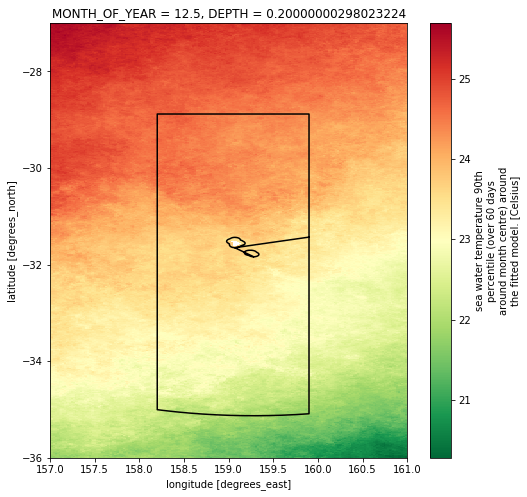

In [373]:
import shapefile as shpf

LH = shpf.Reader(poly_path)
plt.figure(figsize=(8,8))

Dec_90th.plot(cmap='RdYlGn_r')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

**select two years data: 2009 and 2010**

In [374]:
data09 = data.sel(time=slice('2009-01-01','2009-12-31'))
data10 = data.sel(time=slice('2010-01-01','2010-12-31'))

**generate monthly SST data**

In [375]:
data09_g = data09.groupby('time.month')
data10_g = data10.groupby('time.month')

In [376]:
data09_monthly = data09_g.mean('time',keep_attrs=True,skipna=True)
data10_monthly = data10_g.mean('time',keep_attrs=True,skipna=True)

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [428]:
data10_monthly

<xarray.Dataset>
Dimensions:    (latitude: 450, longitude: 200, month: 12)
Coordinates:
  * latitude   (latitude) float64 -27.01 -27.03 -27.05 ... -35.95 -35.97 -35.99
  * longitude  (longitude) float64 157.0 157.0 157.1 157.1 ... 160.9 161.0 161.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst        (month, latitude, longitude) float32 26.988 26.7515 ... 21.508333
Attributes:
    crs:      EPSG:4326

In [452]:
data09_Jan = data09_monthly.sel(month=[1]).sst
data09_Feb = data09_monthly.sel(month=[2]).sst
data09_Mar = data09_monthly.sel(month=[3]).sst
data09_Apr = data09_monthly.sel(month=[4]).sst
data09_May = data09_monthly.sel(month=[5]).sst
data09_Jun = data09_monthly.sel(month=[6]).sst
data09_Jul = data09_monthly.sel(month=[7]).sst
data09_Aug = data09_monthly.sel(month=[8]).sst
data09_Sep = data09_monthly.sel(month=[9]).sst
data09_Oct = data09_monthly.sel(month=[10]).sst
data09_Nov = data09_monthly.sel(month=[11]).sst
data09_Dec = data09_monthly.sel(month=[12]).sst

In [453]:
data10_Jan = data10_monthly.sel(month=[1]).sst
data10_Feb = data10_monthly.sel(month=[2]).sst
data10_Mar = data10_monthly.sel(month=[3]).sst
data10_Apr = data10_monthly.sel(month=[4]).sst
data10_May = data10_monthly.sel(month=[5]).sst
data10_Jun = data10_monthly.sel(month=[6]).sst
data10_Jul = data10_monthly.sel(month=[7]).sst
data10_Aug = data10_monthly.sel(month=[8]).sst
data10_Sep = data10_monthly.sel(month=[9]).sst
data10_Oct = data10_monthly.sel(month=[10]).sst
data10_Nov = data10_monthly.sel(month=[11]).sst
data10_Dec = data10_monthly.sel(month=[12]).sst

**calculate the monthly SST anomalies aganist the SSTAATS 90th percentile data**

In [454]:
diff09_Jan = data09_Jan - Jan_90th
diff09_Feb = data09_Feb - Feb_90th
diff09_Mar = data09_Mar - Mar_90th
diff09_Apr = data09_Apr - Apr_90th
diff09_May = data09_May - May_90th
diff09_Jun = data09_Jun - Jun_90th
diff09_Jul = data09_Jul - Jul_90th
diff09_Aug = data09_Aug - Aug_90th
diff09_Sep = data09_Sep - Sep_90th
diff09_Oct = data09_Oct - Oct_90th
diff09_Nov = data09_Nov - Nov_90th
diff09_Dec = data09_Dec - Dec_90th

In [455]:
diff10_Jan = data10_Jan - Jan_90th
diff10_Feb = data10_Feb - Feb_90th
diff10_Mar = data10_Mar - Mar_90th
diff10_Apr = data10_Apr - Apr_90th
diff10_May = data10_May - May_90th
diff10_Jun = data10_Jun - Jun_90th
diff10_Jul = data10_Jul - Jul_90th
diff10_Aug = data10_Aug - Aug_90th
diff10_Sep = data10_Sep - Sep_90th
diff10_Oct = data10_Oct - Oct_90th
diff10_Nov = data10_Nov - Nov_90th
diff10_Dec = data10_Dec - Dec_90th

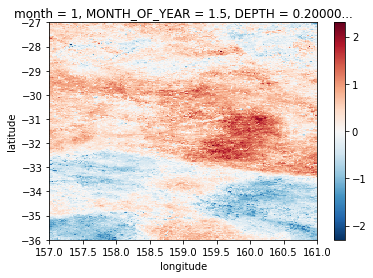

In [458]:
diff10_Jan.plot()

**display the monthly anomaly data**

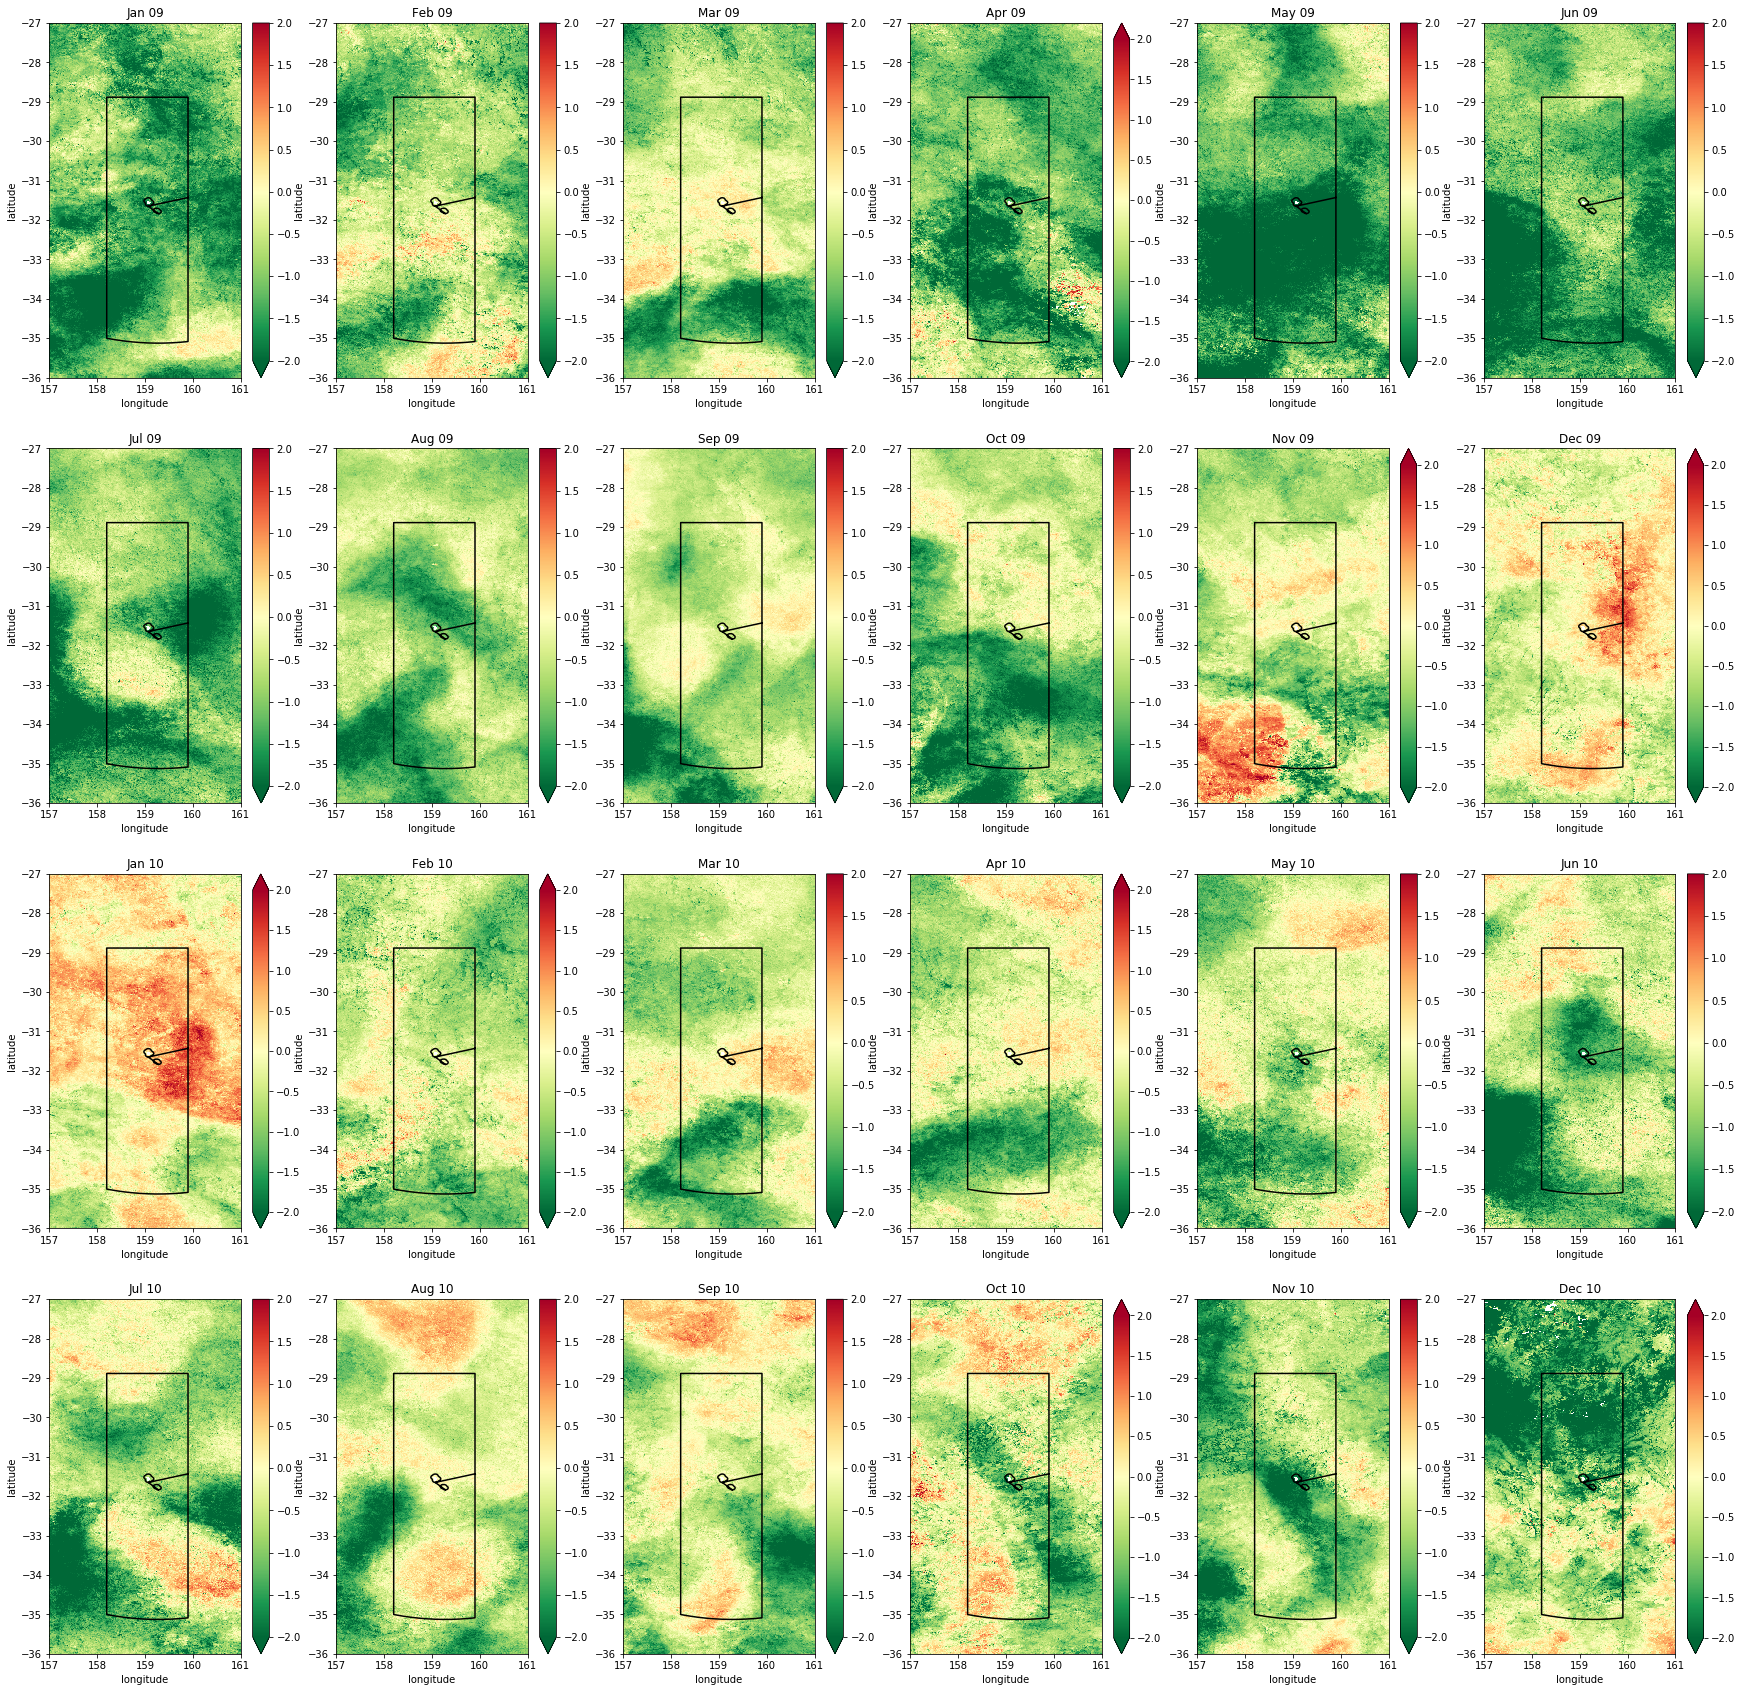

In [462]:
import shapefile as shpf

LH = shpf.Reader(poly_path)
plt.figure(figsize=(30,30))

plt.subplot(4,6,1)
diff09_Jan.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Jan 09')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(4,6,2)
diff09_Feb.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Feb 09')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,3)
diff09_Mar.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Mar 09')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,4)
diff09_Apr.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Apr 09')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,5)
diff09_May.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('May 09')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,6)
diff09_Jun.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Jun 09')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,7)
diff09_Jul.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Jul 09')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,8)
diff09_Aug.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Aug 09')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,9)
diff09_Sep.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Sep 09')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,10)
diff09_Oct.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Oct 09')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,11)
diff09_Nov.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Nov 09')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,12)
diff09_Dec.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Dec 09')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,13)
diff10_Jan.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Jan 10')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(4,6,14)
diff10_Feb.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Feb 10')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,15)
diff10_Mar.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Mar 10')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,16)
diff10_Apr.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Apr 10')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,17)
diff10_May.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('May 10')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,18)
diff10_Jun.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Jun 10')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,19)
diff10_Jul.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Jul 10')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,20)
diff10_Aug.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Aug 10')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,21)
diff10_Sep.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Sep 10')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,22)
diff10_Oct.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Oct 10')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,23)
diff10_Nov.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Nov 10')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,6,24)
diff10_Dec.plot(cmap='RdYlGn_r',vmin=-2,vmax=2)
plt.title('Dec 10')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
